<h2>Data Analytics Homework 2 - David Mallon (08597596) & Paul O'Donovan (22208104)</h2>

Prepare a data quality report for your CSV file. 

In [332]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import RepeatedKFold

import graphviz
from graphviz import Source

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# (1) Data understanding and prep:

The original datasets from the CDC has been cleaned (Homework1) and is now imported as a starting point for this work. 
1. The accompanying data quality report from Homeowork1 can be found attached as PDF as a background to this cleaned dataset;
2. A summary of this plan can be seen in the table below;


In [333]:
# Reading from a csv file, into a data frame
df1 = pd.read_csv('covid19-cdc-22208104.csv', keep_default_na=True, delimiter=',', engine='python', skipinitialspace=True)

# Reading from a csv file, into a data frame
df2 = pd.read_csv('covid19-cdc-8597596.csv', keep_default_na=True, delimiter=',', engine='python', skipinitialspace=True)

# Concatenate the data frames
df = pd.concat([df1, df2], axis=0)

Check how many rows and columns this dataframe has. Also get a summary of columns

In [334]:
print("Number of rows and columns:", df.shape)
df.info()


Number of rows and columns: (40000, 19)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   case_month                       40000 non-null  object 
 1   res_state                        39999 non-null  object 
 2   state_fips_code                  39999 non-null  float64
 3   res_county                       37702 non-null  object 
 4   county_fips_code                 37702 non-null  float64
 5   age_group                        39740 non-null  object 
 6   sex                              39234 non-null  object 
 7   race                             35303 non-null  object 
 8   ethnicity                        34875 non-null  object 
 9   case_positive_specimen_interval  20865 non-null  float64
 10  case_onset_interval              17552 non-null  float64
 11  process                          40000 n

In [335]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
state_fips_code,39999.0,29.556239,13.341753,1.0,19.0,34.0,37.0,78.0
county_fips_code,37702.0,29578.939605,13211.869250,1001.0,18163.0,34017.0,37183.0,56039.0
case_positive_specimen_interval,20865.0,0.194201,2.312371,-90.0,0.0,0.0,0.0,94.0
case_onset_interval,17552.0,-0.057714,1.800305,-60.0,0.0,0.0,0.0,69.0


Per the above results, I am missing 2298 pieces of information for county_fips_code. This is fine in my opinion as I have the almost full 39999 pieces of information for state_fips_code which will suffice for the purposes of this examination. The county_fips_code is not crucial and is sufficiently replaced and supplemented by the state_fips_code data.

In relation to the missing / blank data for case_positive_specimen_interval, I will consider both sets of data in section 2 (my data quality plan) as I will consider their inclusion, possible amendments/corrections and any links that can be made with other provided information.

In [336]:
# Look at column names. Ensure there are not spaces in or after the name
df.columns

Index(['case_month', 'res_state', 'state_fips_code', 'res_county',
       'county_fips_code', 'age_group', 'sex', 'race', 'ethnicity',
       'case_positive_specimen_interval', 'case_onset_interval', 'process',
       'exposure_yn', 'current_status', 'symptom_status', 'hosp_yn', 'icu_yn',
       'death_yn', 'underlying_conditions_yn'],
      dtype='object')

Neither the state_fips_code and county_fips_code data represents a continuous range of values, but instead represent specific states and counties respectively, which are both categorical attributes. Both these datasets are better treated as categorical variables, which will help us understand the distribution of the data and any relationships or patterns that may exist between the state codes and other variables in the dataset.

In [337]:
df["state_fips_code"] = df["state_fips_code"].astype("object")
df["county_fips_code"] = df["county_fips_code"].astype("object")

#Select all columns of type 'object'
object_columns = df.select_dtypes(['object']).columns

#Convert selected columns to type 'category' purely for ease of reference when reviewing categorical and continuous characteristics.
for column in object_columns:
    df[column] = df[column].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   case_month                       40000 non-null  category
 1   res_state                        39999 non-null  category
 2   state_fips_code                  39999 non-null  category
 3   res_county                       37702 non-null  category
 4   county_fips_code                 37702 non-null  category
 5   age_group                        39740 non-null  category
 6   sex                              39234 non-null  category
 7   race                             35303 non-null  category
 8   ethnicity                        34875 non-null  category
 9   case_positive_specimen_interval  20865 non-null  float64 
 10  case_onset_interval              17552 non-null  float64 
 11  process                          40000 non-null  category
 12  expo

Convert the features to their appropriate data types (e.g., decide which features are more appropriate as continuous and which ones as categorical types).

Look for duplicate rows and columns. Consider whether it makes sense to keep them or drop them.

In [338]:
#Print the number of duplicates, without the original rows that were duplicated
print('Number of duplicate (excluding first original occurence) rows in the table is: ', df.duplicated().sum())

# Check for duplicate rows. 
# Use "keep=False" to mark all duplicates as true, including the original rows that were duplicated.
print('Number of duplicate rows (including first original occurence) in the table is:', df[df.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first original occurence) rows in the table is:  3639
Number of duplicate rows (including first original occurence) in the table is: 6178


In [339]:
view_duplicates = df[df.duplicated(keep = False)]
view_duplicates.to_csv('duplicate_columns.csv', index=False)

Having reviewed the duplicates (as set out in a separate csv I prepared), I was satisfied that these should stay in the dataframe. As the information contained therein has been intentionally anonymised, there are not enough specific identifiers relating to each patient's data which would justify removing the duplicates. I believe it better to err on the side of caution and not remove what could (and probably is) information recorded which is identical but actually relates to different individuals, rather than remove valid information on the assumption that it is a duplicate entry.

In [340]:
# quick view of duplicates
duplicate = df[df.duplicated()]
print(duplicate)
 

      case_month res_state state_fips_code   res_county county_fips_code  \
235      2020-03        NY            36.0       QUEENS          36081.0   
274      2021-01        CA             6.0  LOS ANGELES           6037.0   
289      2020-12        CA             6.0  LOS ANGELES           6037.0   
373      2021-01        FL            12.0   MIAMI-DADE          12086.0   
476      2021-12        IL            17.0         COOK          17031.0   
...          ...       ...             ...          ...              ...   
19933    2020-07        TX            48.0      TARRANT          48439.0   
19934    2022-01        IN            18.0       MARION          18097.0   
19941    2021-12        NJ            34.0        OCEAN          34029.0   
19944    2022-01        IN            18.0       GIBSON          18051.0   
19972    2022-01        MN            27.0     HENNEPIN          27053.0   

            age_group      sex     race            ethnicity  \
235         65+ years  

Checking if any duplicate columns present.

Function sourced from https://www.geeksforgeeks.org/how-to-find-drop-duplicate-columns-in-a-pandas-dataframe/ 

In [341]:
def getDuplicateColumns(df):
    duplicateColumnNames = set()
 
    for x in range(df.shape[1]):
        col = df.iloc[:, x]
        for y in range(x + 1, df.shape[1]):
            otherCol = df.iloc[:, y]
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColNames = getDuplicateColumns(df)

for column in duplicateColNames:
    print('Column Name : ', column)

In [342]:
# Check for duplicate columns - additional test
#First transpose the df so columns become rows, then apply the same check as above
dfT = df.T
print("Number of duplicate (excluding first) columns in the table is: ", dfT.duplicated().sum())
print("Number of duplicate (including first) columns in the table is: ",  dfT[dfT.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) columns in the table is:  0
Number of duplicate (including first) columns in the table is:  0


Look for constant columns. Consider whether it makes sense to keep them or drop them.

In [343]:
# Check the number of unique values in each column
nunique_values = df.nunique()

constant_columns = nunique_values[nunique_values == 1].index
constant_column_names = list(constant_columns)

# Print the names of the constant columns
print("Constant columns: ", constant_column_names)

Constant columns:  []


In [344]:
c = [c for c in df.columns if len(set(df[c])) == 1]
print ("Constant columns: ", c)

Constant columns:  []


There are no 100% constant columns present in my dataset, therefore no adjustment is required.
I have rechecked the data basing it on a 90% occurrence (when excluding empty cells) for completeness per the below cells and I would opine that the information in both the 'process' and 'underlying_conditions_yn' cells warrant inclusion in the cleaned dataframe due to weighing up the results against the number of empty cells with missing information. Further examination of these features is undertaken in part two of this assignment.

In [345]:
#Calculate the percentage of each value in each column, including empty cells
value_percentages = df.apply(lambda x: x.value_counts(normalize=True, dropna=False).max())

#Select only the columns where the maximum value percentage is >= 0.95
constant_columns = value_percentages[value_percentages >= 0.90].index

#List the names of the constant columns
constant_column_names = list(constant_columns)

#Print the names of the constant columns
print("Constant columns: ", constant_column_names)

Constant columns:  ['process', 'underlying_conditions_yn']


The information from 'underlying_conditions_yn' is still useful when looking for consideration based on the above commentary. This information will also be useful when preparing my data quality plan and expected results from the bar plots. Further commentary is provided on my logic is provided in both my Data Quality Report and Data Quality Plan.

In [346]:
df['underlying_conditions_yn'].value_counts()

Yes    3444
No       51
Name: underlying_conditions_yn, dtype: int64

case_onset_interval - Drop column as this feature has little effect on target outcome <br>
case_positive_specimen_interval - Drop column as this feature has little effect on target outcome<br>
res_county - Drop column as it is like a duplicate feature to county_fips_code and it is not a unique identifier (eg county with same name in different states).<br>
process - Drop column as this feature has little effect on target outcome and has most values missing.<br>
exposure_yn - Drop column as this feature has little effect on target outcome and has most values missing.<br>
symptom_status - Drop column as this feature has little effect on target outcome and is missing >50% of values<br>


Convert unknown and null to missing, and take missing values into account when analysing data for the following; <br>
age_group<br>
sex<br>
race <br>
ethnicity<br>
hosp_yn<br>
icu_yn<br>


Convert null to missing, and take missing values into account when analysing data 
underlying_conditions_yn

In [347]:
# drop the specified columns
df = df.drop(columns=["case_onset_interval", "case_positive_specimen_interval", "res_county", "process", "exposure_yn", "symptom_status", "state_fips_code"])

In [348]:
# replace "unknown" and "null" values with NaN
df = df.replace(["unknown", "null"], np.nan)

In [349]:
# replace "null" values with NaN
df["underlying_conditions_yn"] = df["underlying_conditions_yn"].replace("null", np.nan)

# Q. Save your updated/cleaned data frame to a new csv file.

In [350]:
# Reading cleaned data into a data frame
df = pd.read_csv('cleaned_data_hw2.csv')

#Select all columns of type 'object'
object_columns = df.select_dtypes(['object']).columns

#Convert selected columns to type 'category' purely for ease of reference when reviewing categorical and continuous characteristics.
for column in object_columns:
    df[column] = df[column].astype('category')

# Convert case_month to datetime format
df['case_month'] = pd.to_datetime(df['case_month'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   case_month                40000 non-null  category
 1   res_state                 39999 non-null  category
 2   county_fips_code          37702 non-null  float64 
 3   age_group                 39740 non-null  category
 4   sex                       39234 non-null  category
 5   race                      35303 non-null  category
 6   ethnicity                 34875 non-null  category
 7   current_status            40000 non-null  category
 8   hosp_yn                   40000 non-null  category
 9   icu_yn                    40000 non-null  category
 10  death_yn                  40000 non-null  category
 11  underlying_conditions_yn  3495 non-null   category
dtypes: category(11), float64(1)
memory usage: 746.8 KB


In [351]:
df.to_csv('cleaned_data_hw2.csv', index=False)

# (1) Data understanding and prep:

The original datasets from the CDC has been cleaned (Homework1) and is now imported as a starting point for this work. 
1. The accompanying data quality report from Homeowork1 can be found attached as PDF as a background to this cleaned dataset;
2. A summary of this plan can be seen in the table below;

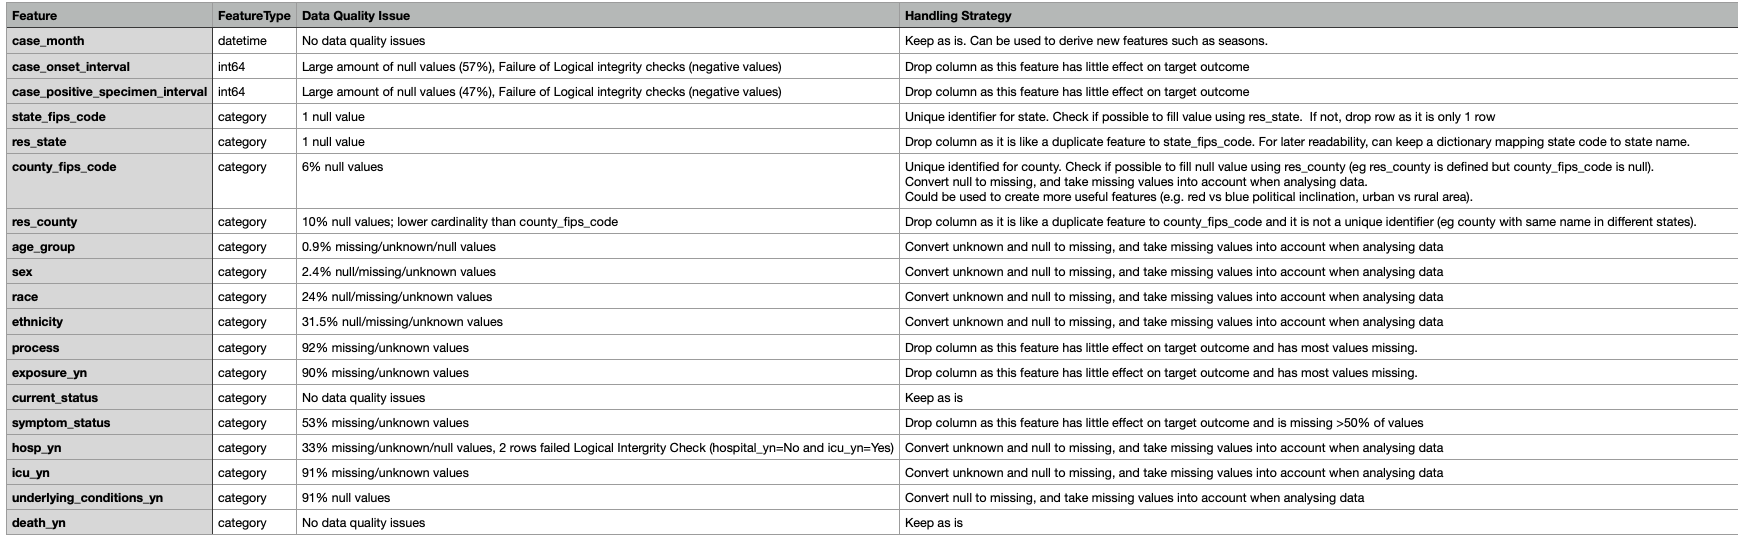

The goal in this homework is to work with the data to build and evaluate prediction models that capture the relationship between the descriptive features and the target feature **death_yn**. For this homework you are asked to use the same dataset allocated to you in Homework1 (you can use your cleaned/prepared CSV from Homework1 or start from the raw dataset, clean it according to concepts covered in the lectures/labs, then use it for training prediction models). To use the 2 individual files allocated for Homework1, you can merge them first, then clean the resulting dataset, before starting on Homework2 requirements.
 
There are 5 parts for this homework. Each part has an indicative maximum percentage given in brackets, e.g., part (1) has a maximum of 25% shown as [25]. The total that can be achieved is 100.


(1). [25] **Data Understanding and Preparation:** Exploring relationships between feature pairs and selecting/transforming promising features based on a given training set.

    
    

After importing the cleaned csv, as a reminder we will check the shape, inspect the datatypes and check for any remaining null values

In [352]:
df.shape

(40000, 12)

In [353]:
df.dtypes

case_month                  category
res_state                   category
county_fips_code             float64
age_group                   category
sex                         category
race                        category
ethnicity                   category
current_status              category
hosp_yn                     category
icu_yn                      category
death_yn                    category
underlying_conditions_yn    category
dtype: object

In [354]:
df.isna().sum()

case_month                      0
res_state                       1
county_fips_code             2298
age_group                     260
sex                           766
race                         4697
ethnicity                    5125
current_status                  0
hosp_yn                         0
icu_yn                          0
death_yn                        0
underlying_conditions_yn    36505
dtype: int64

Convert unknown and null to missing

In [355]:
df.replace(['unknown', 'null'], 'Missing', inplace=True)

In [356]:
unique_values = df.nunique()

print(unique_values)

case_month                    35
res_state                     49
county_fips_code            1340
age_group                      5
sex                            4
race                           8
ethnicity                      4
current_status                 2
hosp_yn                        4
icu_yn                         4
death_yn                       2
underlying_conditions_yn       2
dtype: int64


- (1.1) Split the dataset into two datasets: 70% training and 30% test. Keep the test set aside.

In [357]:
df.to_csv('cleaned_data_hw2.csv', index=False)

In [358]:
# read in the cleaned csv
df = pd.read_csv("cleaned_data_hw2.csv", keep_default_na=True, delimiter=',', skipinitialspace=True)
df.head(5)

,case_month,res_state,county_fips_code,age_group,sex,race,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2021-04-01,IL,17031.0,50 to 64 years,Male,White,Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,NaN
1,2020-04-01,MA,25025.0,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,NaN
2,2020-11-01,PA,42101.0,65+ years,Female,White,Unknown,Laboratory-confirmed case,Unknown,Unknown,Yes,NaN
3,2021-12-01,NY,36081.0,65+ years,Female,Asian,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Yes,Yes,Yes
4,2022-01-01,AZ,4013.0,65+ years,Male,White,Non-Hispanic/Latino,Probable Case,Missing,Missing,Yes,NaN


In [359]:
df.shape

(40000, 12)

In [360]:
df.dtypes

case_month                   object
res_state                    object
county_fips_code            float64
age_group                    object
sex                          object
race                         object
ethnicity                    object
current_status               object
hosp_yn                      object
icu_yn                       object
death_yn                     object
underlying_conditions_yn     object
dtype: object

In [361]:
df.isna().sum()

case_month                      0
res_state                       1
county_fips_code             2298
age_group                     260
sex                           766
race                         4697
ethnicity                    5125
current_status                  0
hosp_yn                         0
icu_yn                          0
death_yn                        0
underlying_conditions_yn    36505
dtype: int64

#### Convert datatypes for plotting later
We will now review the datatypes and convert if needed. This will help avoid plotting errors later in the notebook
- The target feature "death_yn" is type object, with values "Yes" & "No". These will be mapped 'Yes': 1, "No": 0 and stored as "int64"

In [362]:
# convert 'death_yn' to 0,1
df['death_yn'] = df['death_yn'].map({'Yes': 1, "No": 0})

#### Deal with NaN values
NaN values appear in the features will need to be dealt with (removed) before any modeling takes place
- We will look at 3 options to deal with theses NaN values;
     1. Perform imputation with the median
     2. Replace with strange value e.g. 999
     3. Drop the feature
- Each of these options will be evaluated and one will be chosen
- Two additional features will now be created to capture these options 

county_fips_code: This feature has 2298 missing values, which is relatively small compared to the total number of observations. Therefore, imputation with the median or replacement with a strange value may be appropriate in this case.



In [363]:
#replace missing values in county_fips_code with -1
df['county_fips_code'].fillna(-1, inplace=True)

# check the number of missing values in county_fips_code
print("Number of missing values in county_fips_code:", df['county_fips_code'].isnull().sum())

Number of missing values in county_fips_code: 0


age_group, sex, race, ethnicity, underlying_conditions_yn: These features have a high number of missing values, ranging from 260 to 36505. Dropping these features may be the best option since imputation or replacement with a strange value may result in the loss of too much information. However, you should carefully evaluate the importance of these features and their impact on the analysis before dropping them.

In [364]:
# convert case_month feature to datetime
df['case_month'] = pd.to_datetime(df['case_month'])

# impute missing values with the mode for each feature except for county_fips_code and res_state
for column in df.columns:
    if column not in ['county_fips_code', 'res_state']:
        df[column].fillna(df[column].mode()[0], inplace=True)

# drop rows with missing values in res_state
df.dropna(subset=['res_state'], inplace=True)

# check the number of missing values in each feature
print("Number of missing values in each feature:\n", df.isnull().sum())

Number of missing values in each feature:
 case_month                  0
res_state                   0
county_fips_code            0
age_group                   0
sex                         0
race                        0
ethnicity                   0
current_status              0
hosp_yn                     0
icu_yn                      0
death_yn                    0
underlying_conditions_yn    0
dtype: int64


Show correlation with the target for each feature

In [365]:
# compute the correlation between each feature and the target feature (death_yn)
corr_with_target = df.corrwith(df['death_yn'])

# print the correlation with the target for each feature
print("Correlation with the target (death_yn) for each feature:\n", corr_with_target)

Correlation with the target (death_yn) for each feature:
 county_fips_code   -0.202333
death_yn            1.000000
dtype: float64


In [366]:
df.shape

(39999, 12)

In [367]:
df.dtypes

case_month                  datetime64[ns]
res_state                           object
county_fips_code                   float64
age_group                           object
sex                                 object
race                                object
ethnicity                           object
current_status                      object
hosp_yn                             object
icu_yn                              object
death_yn                             int64
underlying_conditions_yn            object
dtype: object

In [368]:
df.isna().sum()

case_month                  0
res_state                   0
county_fips_code            0
age_group                   0
sex                         0
race                        0
ethnicity                   0
current_status              0
hosp_yn                     0
icu_yn                      0
death_yn                    0
underlying_conditions_yn    0
dtype: int64

#### Setup Column types
We will now setup the continuous, categorical, target features

##### Select all categorical columns and convert to categorical type
 - This will be needed later when it will be required to convert categorical features into dummy features for modeling

In [369]:
# Select columns containing categorical data
categorical_columns = df[["res_state","age_group","sex","race","ethnicity","current_status","hosp_yn","icu_yn","underlying_conditions_yn"]].columns

# Convert data type to category for these columns
for column in categorical_columns:
    df[column] = df[column].astype('category')

df[categorical_columns].dtypes

res_state                   category
age_group                   category
sex                         category
race                        category
ethnicity                   category
current_status              category
hosp_yn                     category
icu_yn                      category
underlying_conditions_yn    category
dtype: object

##### Setup continuous columns as all the remaining columns that are not category i.e. they are int64

In [370]:
# convert county_fips_code to an integer data type
df['county_fips_code'] = df['county_fips_code'].astype('int64')

# check the data type of the converted column
print(df['county_fips_code'].dtypes)

# select continuous columns
continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns

# check the data types of the selected columns
print(df[continuous_columns].dtypes)

int64
county_fips_code    int64
death_yn            int64
dtype: object


In [371]:
df.dtypes

case_month                  datetime64[ns]
res_state                         category
county_fips_code                     int64
age_group                         category
sex                               category
race                              category
ethnicity                         category
current_status                    category
hosp_yn                           category
icu_yn                            category
death_yn                             int64
underlying_conditions_yn          category
dtype: object

##### We will now shuffle the dataframe before splitting the dataset
- This step is strictly not necessary as performing train/test split will also shuffle the dataframe

In [372]:
# randomly generate sequence based on dataframe index and set to be new index
df.set_index(np.random.permutation(df.index))
# sort the resulting random index
df.sort_index(inplace=True)
df.head(5)

,case_month,res_state,county_fips_code,age_group,sex,race,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2021-04-01,IL,17031,50 to 64 years,Male,White,Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,1,Yes
1,2020-04-01,MA,25025,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,1,Yes
2,2020-11-01,PA,42101,65+ years,Female,White,Unknown,Laboratory-confirmed case,Unknown,Unknown,1,Yes
3,2021-12-01,NY,36081,65+ years,Female,Asian,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Yes,1,Yes
4,2022-01-01,AZ,4013,65+ years,Male,White,Non-Hispanic/Latino,Probable Case,Missing,Missing,1,Yes


##### The dataset will now be split into two datasets: 70% training and 30% test
- First we will set the target feature "y" to be death_yn
- Then we will set "X" to be the remaining features in the dataframe i.e. we drop "death_yn" from the dataframe

In [373]:
y = pd.DataFrame(df["death_yn"])
X = df#.drop(["death_yn"],1)

##### The data set can now be split
- The train test split will randomly split the dataset as per the test size
- We will set the random state=1 to allow the random shuffle to be repeated within this notebook only

In [374]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  39999
training range (70%):	 rows 0 to 27999
test range (30%): 	 rows 27999 to 39999


## 1.2 On the training set we will now carry out a series of plots comparing all features to help make decisions on what features to keep for the model 

- All plots will be using the training subset of dataset: X_train, y_train

### 1.2.1 Plot the correlations between all the continuous features. 

(array([0.5, 1.5]),
 [Text(0.5, 0, 'county_fips_code'), Text(1.5, 0, 'death_yn')])

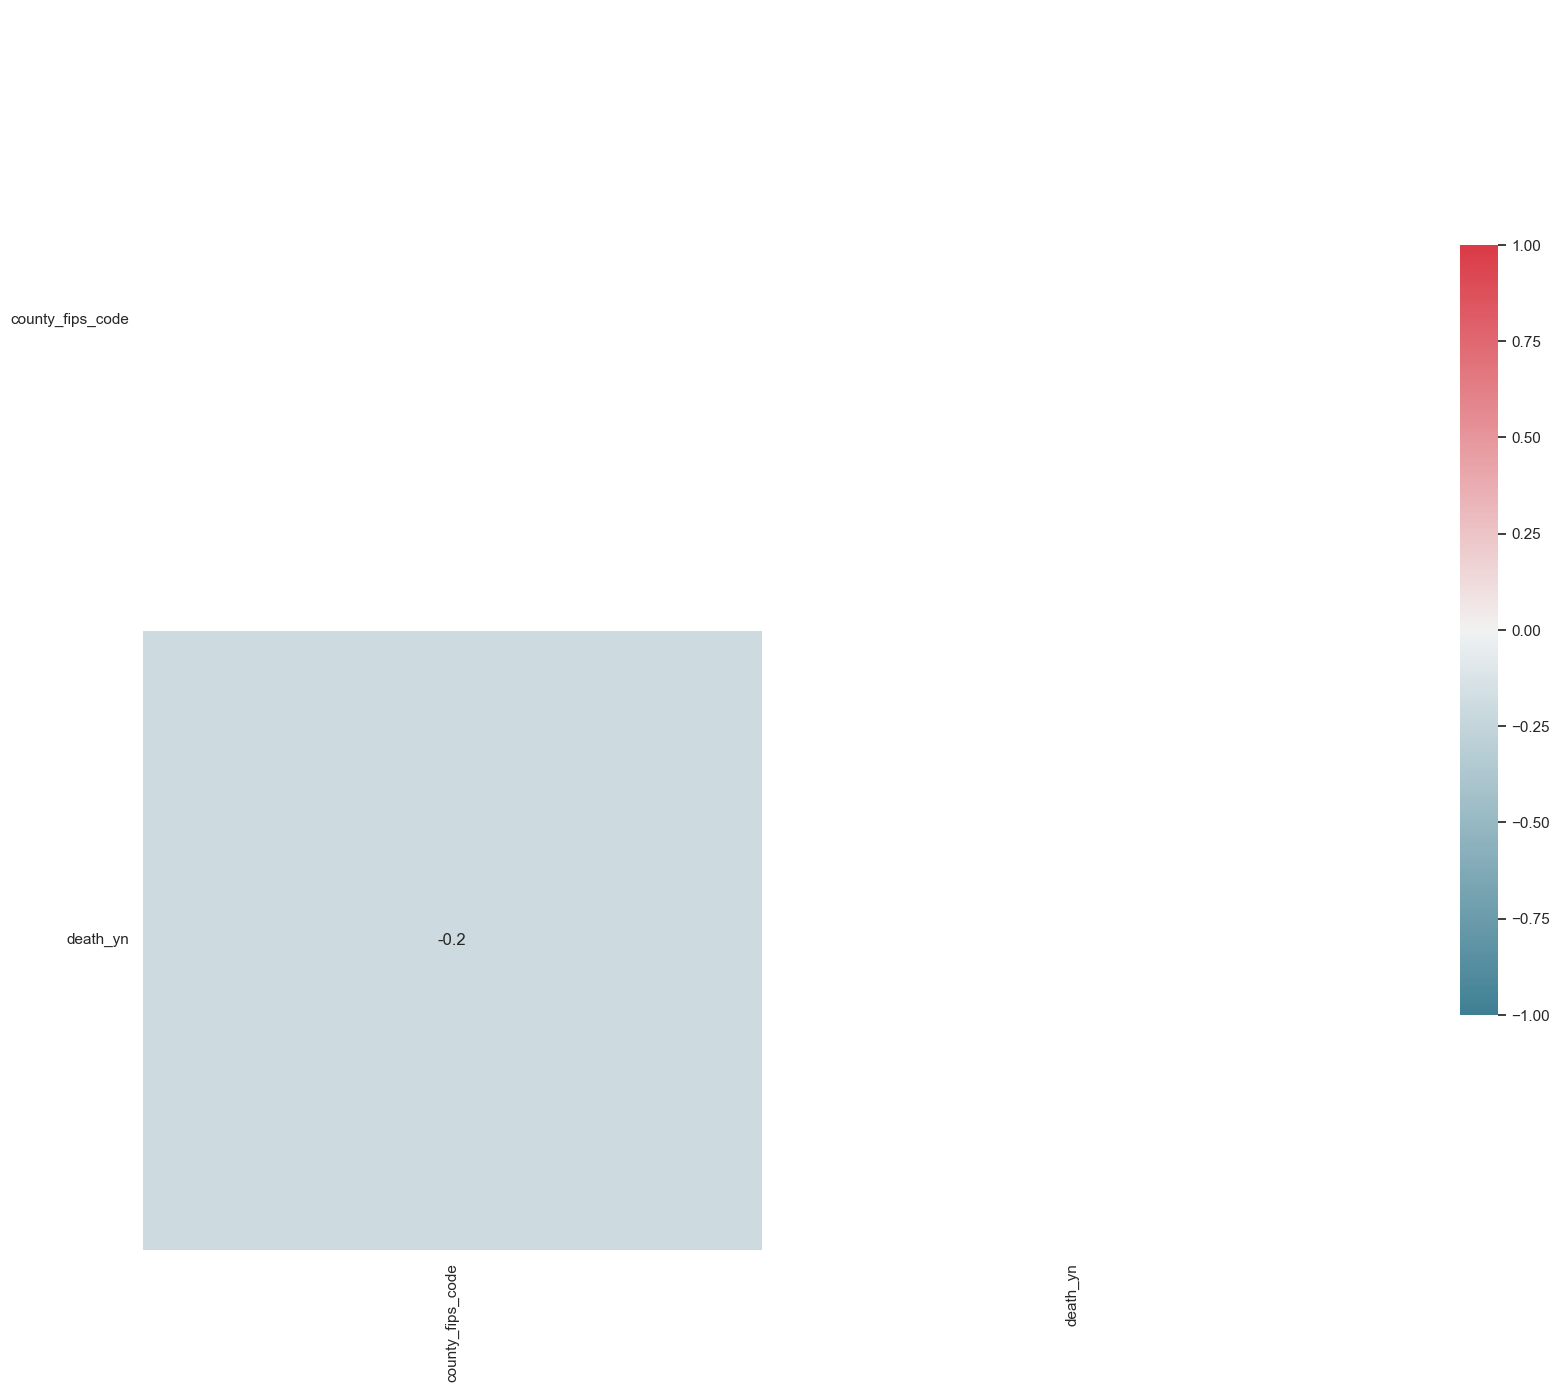

In [375]:
# Set style to white
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = X_train[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

#### Interpretation of the results

### 1.2.2 Plot interaction between continuous features and target feature
- Here we will loop over each continuous feature and make a scatter plot against the target 'death_yn'
- We will discuss what we observe from these plots, e.g. which continuous features seem to be better at predicting the target feature
- We will choose a subset of continuous features we find promising (if any) and justify our choice.

Note: death_yn needs to be an int for these scatter plots, as we have prepared earlier

,death_yn
death_yn,1.000000
county_fips_code,-0.200739


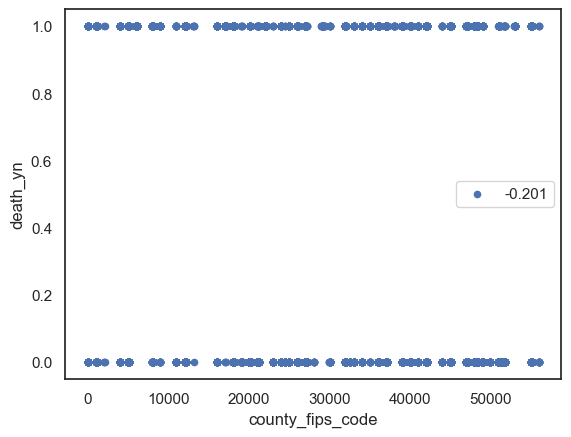

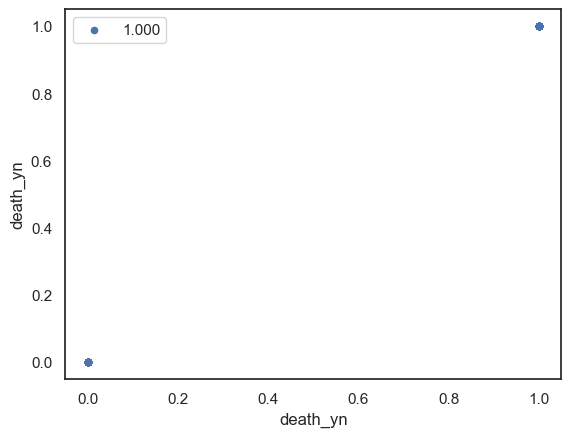

In [376]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_train[continuous_columns]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "death_yn"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="death_yn", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['death_yn']).sort_values('death_yn', ascending=False)
corr_df

#### 1.2.3 Interpretation of the results
- Observing the plots, visually there are no clearly defined correlations and this is probably to be expected with a complex problem like this. There are many interactions to take into account.
- Reviewing the sorted correlation dataframe we get a better overview of all the correlations. 
- We will breakdown the correlation values into 3 bins for purposes of interpretation taking only their absolute value into account
- Note: The bounds for each bin are arbitrary and for the purpose of splitting up the features only. 


| Low correlation | Medium correlation | High correlation |
|-----------------|--------------------|------------------|
| x <= 0.15       | 0.15 < x < 0.25    | x >= 0.25        |
| 0 features      | 1  features        | 0 features       |
| 0%              | 100%               | 0%               | 


- county_fips_code has a medium negative correlation 
- I will not interpret each feature individually are there are simply too many to explore.- I will decide to keep the features that fall into the medium and high correlation bins. 
- The impact of this decision will be evaluated in part 5.

In [ ]:
# generate list of features for high correlation bin
medium_correlation_features = []
for key, value in corr_dict.items():
    if value > 0.15 or value < -0.25:
        medium_correlation_features.append(key)
medium_correlation_features

### 1.2.3 Plot interaction between categorical features and target feature
- Here we will plot a pairwise interaction between each categorical feature against the target feature. 
- We will discuss what we observe from these plots, e.g., which categorical features seem to be better at predicting the target feature...
- We will choose a subset of categorical features we find promising (if any) and justify our choice.

Here we have 9 categorical features
- res_state, age_group, sex, race, ethnicity , current_status, hosp_yn, icu_yn, underlying_conditions_yn
- A stacked bar plot for each will be created.

##### Create stacked bar plots for all categorical features

In [378]:
# for the comparison we will convert the target back to categorical
y_train = y_train.astype("category")
#X_train[categorical_columns].columns

# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([X_train, y_train], axis=1)


# for each categorical feature create a stacked bar plot
for categorical_feature in categorical_columns:
    # Using code from the module lab

    maxDelqEver = pd.unique(df_temp[categorical_feature].ravel())

    # add new column and set values to zero
    df_temp['percent'] = 0

    #print header
    print("\n", categorical_feature)
    print("Index \t Count")

    # for each delinquency category
    for i in maxDelqEver:

        count = df_temp[df_temp[categorical_feature] == i].count()['death_yn']
        count_percentage = (1 / count) * 100

        # print out index vs count
        print(i, "\t", count)

        index_list = df_temp[df_temp[categorical_feature] == i].index.tolist()
        for ind in index_list:
            print(ind)  # Debugging line
            df_temp.at[ind, 'percent'] = count_percentage

    group = df_temp[['percent',categorical_feature,'death_yn']].groupby([categorical_feature,'death_yn']).sum()

    my_plot = group.unstack().plot(kind='bar', stacked=True, title=f"death_yn vs {categorical_feature}", figsize=(15,7), grid=True)

    # add legend
    red_patch = mpatches.Patch(color='orange', label='Good')
    blue_patch = mpatches.Patch(color='blue', label='Bad')
    my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

    # add gridlines
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    # add labels
    my_plot.set_xlabel("Delinquency index")
    my_plot.set_ylabel("% Risk")
    my_plot.set_ylim([0,100])

# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop("percent", 1)


 res_state
Index 	 Count
MN 	 death_yn    1294
death_yn    1294
dtype: int64
28530


ValueError: Incompatible indexer with Series